# Get_Template: 
This script constructs a very simple `template` of a miyake event. The sinusoidal component of the production function is ignored resulting in a smooth curve. The template is constructed using the best fitting `model`-`dataset` pair  from the 774AD year. `emcee` is used to fit the parameters of the production function which is then used to generate the `.csv` file containing the `dc14` concentrations over just the event.

In [280]:
from os import getcwd
from numpy import exp, array, append, vectorize, mean, transpose, log
from numpy import float32
from functools import partial
from scipy.optimize import minimize
from scipy.integrate import odeint
from plotnine import ggplot, aes, geom_point, geom_line, theme_bw


In [130]:
YEAR = 0
DC14 = 1
SIG_DC14 = 2

In [131]:
with open(f"{getcwd()}/datasets/775AD/NH/Miyake12_Cedar.csv") as data:
    _ = next(data)  # Removing the header
    data = array([row.strip().split(",") for row in data], dtype=float32)
    data = transpose(data)

So for just modelling the troposphere I will want to set things up so that I have a differential equation where $f(x) = e^{x^{8}}$ is the rate of change. I will then use `scipy.optimize.minimize()` to minimize a loss function with respect to the solution of the ode as determined by the `return` of `ode.odeint`. 

So I am going to assume that based on `y0` the system is in equilibrium. Thus I will add a constant term to `production` that is based on `y0` times the `decay constant. Ahh so the problem is that there is a rapid outflow to the connected cells in the carbon box model. I can just add some multiple factor `OUTFLOW` which acts on the difference between the current troposphere value and `y0`

In [282]:
def dydx(y, t, *params, y0=None):
    """
    Computes an approximation to the gradient within the troposphere only. This works by accounting for the outflow to other boxes via a tunable `outflow` parameter, ignoring the details of this transaction. This gradient assumes that the initial state of the system represents and equilibrium position and acts accordingly. 
    """
    out_flow, *prod_params = params
    def production(t, *prod_params):
        peak, span, height = prod_params  # Loading parameters
        gauss = height * exp(-((t - peak) / (span / 2)) ** 2)   # Gaussian pulse
        return gauss
    return - out_flow * (y - y0) + production(t, *prod_params)

In [ ]:
y0 = mean(data[DC14][:4])
dydx = partial(dydx, y0=y0)

attempt = odeint(
    func=dydx, 
    y0=y0, 
    t=data[YEAR], 
    args=(0.05, 775,2,10),
    rtol=1e-10,
    atol=1e-10,
    tcrit=array([775])
)

In [278]:
def loss(params, data, ):
    def dydx(y, t, *params, y0=None):
        """
        Computes an approximation to the gradient within the troposphere only. This works by accounting for the outflow to other boxes via a tunable `outflow` parameter, ignoring the details of this transaction. This gradient assumes that the initial state of the system represents and equilibrium position and acts accordingly. 
        """
        out_flow, *prod_params = params
        def production(t, *prod_params):
            peak, span, height = prod_params  # Loading parameters
            gauss = height * exp(-((t - peak) / (span / 2)) ** 2)   # Gaussian pulse
            return gauss
        return - out_flow * (y - y0) + production(t, *prod_params)
        
    y0 = mean(data[DC14][:4])
    dydx = partial(dydx, y0=y0)

    attempt = odeint(
        func=dydx, 
        y0=y0, 
        t=data[YEAR], 
        args=(0.05, 775,2,10),
        rtol=1e-10,
        atol=1e-10,
        tcrit=array([775])
    )
    


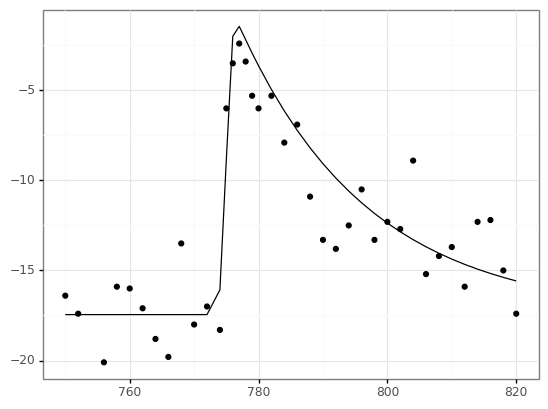

<ggplot: (8735288364225)>

In [281]:
(ggplot()
    + geom_line(
        aes(x=data[YEAR], y=attempt)
    ) + geom_point(
        aes(x=data[YEAR], y=data[DC14])
    ) + theme_bw()
)

`pandas.read_csv`: 1.02 ms ± 65.6 µs

`list` with `append`: 57.5 µs ± 3.6 µs

`ndarray` with `append`: 668 µs ± 60.6 µs 

`ndarray` with `map`, `numpy.append`: 38.2 µs ± 4.07 µs

`ndarray` with `map`, `add_row`: 17.7 µs ± 1.34 µs 

`list` with `numpy.array` conversion at the end: 53.7 µs ± 3.14 µs